Fixing the model

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import cross_val_score


Load the Dataset

In [248]:
#load the dataset and sample some
data = pd.read_csv(r'D:\lums\work stuff\notebooks\BostonHousing.csv')
print(data.describe())

print("Original data shape:", data.shape)

# # Check unique values in 'chas' column
# print("Unique values in 'chas':", data['chas'].unique().sum())

             crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  501.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284341   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.705587   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.884000   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208000   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.625000   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio           b  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

In [249]:
# Check for missing values
for column in data.columns:
    missing = data[column].isnull().sum()
    if missing > 0:
        print(f"{column} has {missing} missing values")

# Check for duplicates
duplicates = data.duplicated().sum()
if duplicates > 0:
    print(f"There are {duplicates} duplicate rows in the dataset")
else:
    print("No duplicate rows found in the dataset")
    

rm has 5 missing values
No duplicate rows found in the dataset


In [250]:
# Fill missing values if any
data['rm'] = data['rm'].fillna(data['rm'].mean())

# Check for missing values
for column in data.columns:
    missing = data[column].isnull().sum()
    if missing > 0:
        print(f"{column} has {missing} missing values")

In [251]:
# Function to remove outliers
def remove_outliers(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 2.5 * IQR
        upper_bound = Q3 + 2.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

data.shape

data_clean = remove_outliers(data)

X = data_clean.drop(['medv', 'chas'], axis=1)
y = data_clean['medv']

data_clean.shape


(272, 14)

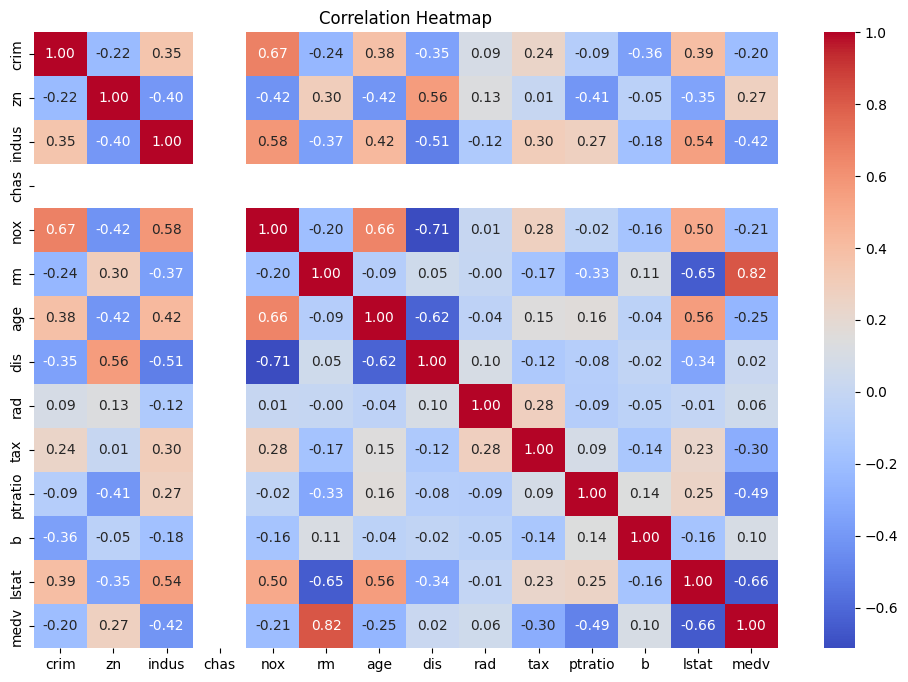

Correlations with target variable (medv):
medv       1.000000
rm         0.816004
zn         0.274670
b          0.097855
rad        0.055596
dis        0.017619
crim      -0.202031
nox       -0.208796
age       -0.247462
tax       -0.295840
indus     -0.415619
ptratio   -0.493224
lstat     -0.656889
chas            NaN
Name: medv, dtype: float64


In [252]:
# correlation chart against target variable
plt.figure(figsize=(12, 8))
correlation = data_clean.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# correlations against target variable
correlations = data_clean.corr()['medv'].sort_values(ascending=False)
print("Correlations with target variable (medv):")
print(correlations)

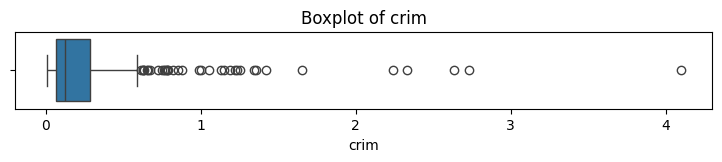

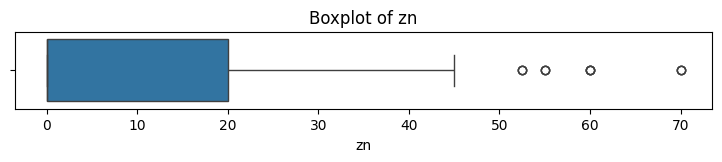

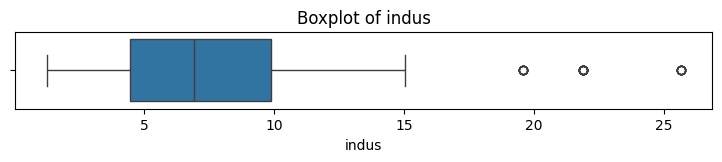

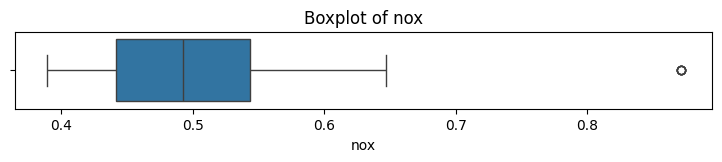

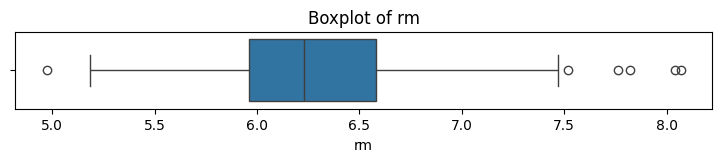

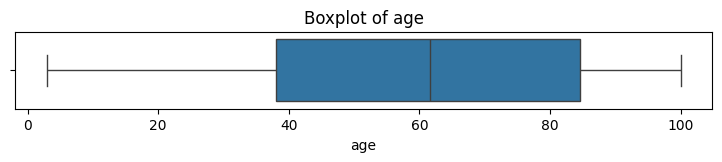

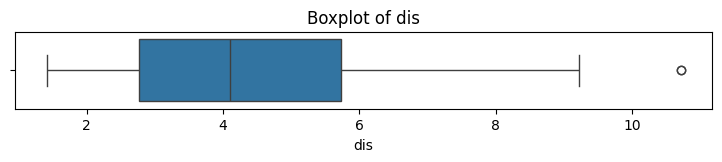

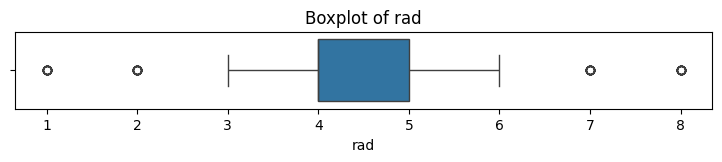

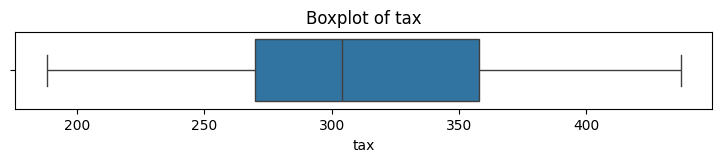

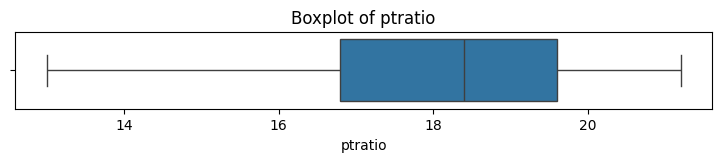

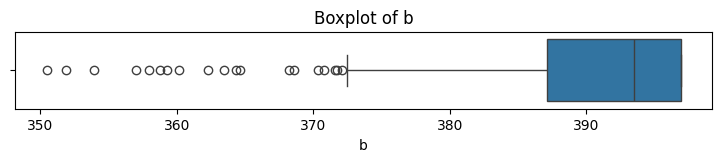

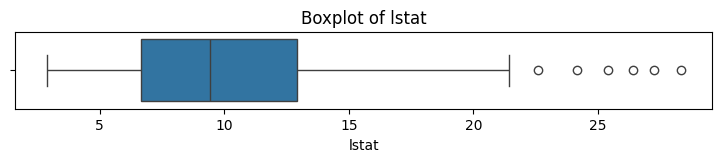

In [253]:
# for col in X.columns:
#     plt.figure(figsize=(6, 4))
#     plt.scatter(data_clean[col], y, alpha=0.5)
#     plt.xlabel(col)
#     plt.ylabel('medv')
#     plt.title(f'{col} vs medv')
#     plt.show()

for col in X.columns:
    plt.figure(figsize=(9, 1))
    sns.boxplot(x=data_clean[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [254]:
# train test spilt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Scale Features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

train_pred = model.predict(X_train_scaled)
test_pred = model.predict(X_test_scaled)

# print(test_pred)

#MSE and R^2

print("Linear Regression Model Performance:")
print("Train MSE:", mean_squared_error(y_train, train_pred))
print("Test MSE:", mean_squared_error(y_test, test_pred))
print("Train R^2:", r2_score(y_train, train_pred))
print("Test R^2:", r2_score(y_test, test_pred))

Linear Regression Model Performance:
Train MSE: 7.064658475466377
Test MSE: 7.175125691538237
Train R^2: 0.8068463106402166
Test R^2: 0.7895823706631651


In [255]:
from sklearn.linear_model import Ridge, Lasso

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
selected_features = np.where(lasso.coef_ != 0)[0]

print(selected_features)

X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_selected, y_train)
rf_pred = rf.predict(X_test_selected)

print("\nRandom Forest Regression Performance:")
print("Test MSE:", mean_squared_error(y_test, rf_pred))
print("Test R^2:", r2_score(y_test, rf_pred))

[ 1  2  4  5  6  7  8  9 10 11]

Random Forest Regression Performance:
Test MSE: 7.926426363636343
Test R^2: 0.7675497383249624


In [256]:
# Save the trained model and scaler for use in Streamlit
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved as model.pkl and scaler.pkl")

Model and scaler saved as model.pkl and scaler.pkl


Residual plot

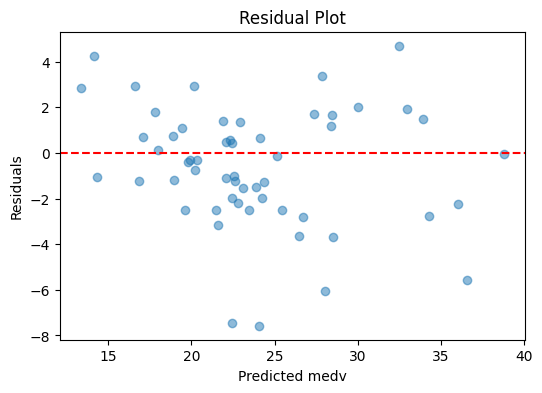

In [257]:
# Plotting residuals
residuals = y_test - test_pred
plt.figure(figsize=(6, 4))
plt.scatter(test_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted medv')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

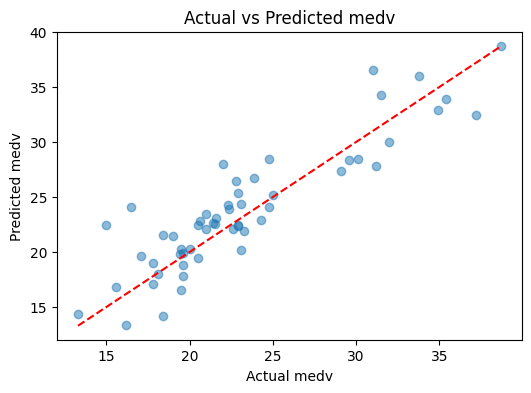

In [258]:
# Plotting actual vs predicted values
plt.figure(figsize=(6, 4))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual medv')
plt.ylabel('Predicted medv')
plt.title('Actual vs Predicted medv')
plt.show()